In [ ]:
import numpy as np
from SquareDivision.src.rectangle_class import Rectangulation
from SquareDivision.src.distributions import FromFunction, BetweenFunctions, tepui, surface_perp_to, cross_ABCD

rects = Rectangulation(config={"seed": 12345378})

# tepui_kwargs_width = {
#     'top' : 0.3, 
#     'bottom' : 0.02, 
#     'slope' : 3, 
#     'vertex' : 0.5, 
#     'pts' : np.array([[0.25, 0.25],[0.75, 0.75]])
#     }
# tepui_kwargs_height = {
#     'top' : 0.3, 
#     'bottom' : 0.02, 
#     'slope' : 3, 
#     'vertex' : 0.5, 
#     'pts' : np.array([[0.75, 0.25],[0.25, 0.75]])
#     }

# width_0 = lambda mid_pt: tepui(mid_pt, **tepui_kwargs_width)
# width_1 = width_0
# height_0 = lambda mid_pt: tepui(mid_pt, **tepui_kwargs_height)
# height_1 = height_0

cross_ABCD_kwargs = {'bottom':0.005,'slope':0.3,'ax':0.625, 'ay':0.625, 'bx':0.875, 'by':0.875, 'cx':0.125, "cy":0.375, 'dx':0.375, 'dy':0.125}
width_0 = lambda mid_pt: cross_ABCD(mid_pt, **cross_ABCD_kwargs)
width_1 = width_0
height_0 = lambda mid_pt: cross_ABCD(mid_pt, **cross_ABCD_kwargs)
height_1 = height_0

# #### Crosses
# cross_ABCD_kwargs_upperleft = {'bottom':0.02,'slope':0.4,'ax': 0.125, 'ay':0.75, 'bx':0.375, 'by':0.75, 'cx':0.25, "cy":0.625, 'dx':0.25, 'dy':0.875}
# cross_ABCD_kwargs_downright = {'bottom':0.02,'slope':0.4,'ax': 0.625, 'ay':0.25, 'bx':0.875, 'by':0.25, 'cx':0.75, "cy":0.125, 'dx':0.75, 'dy':0.375}
# width_0 = lambda mid_pt: min(cross_ABCD(mid_pt, **cross_ABCD_kwargs_upperleft),cross_ABCD(mid_pt, **cross_ABCD_kwargs_downright))
# width_1 = width_0
# height_0 = lambda mid_pt: min(cross_ABCD(mid_pt, **cross_ABCD_kwargs_upperleft),cross_ABCD(mid_pt, **cross_ABCD_kwargs_downright))
# height_1 = height_0

rects.sample_rectangles(
    num=5000, 
    widths_strategy = BetweenFunctions(func_0=width_0, func_1=width_1, rng=rects.rng), 
    heights_strategy= BetweenFunctions(func_0=height_0, func_1=height_1, rng=rects.rng), 
)
rects.perform()
rects.report(tol=0.01, digits=4, limit_list=3)
rects.draw(disjoint=True, disjoint_nums=False, inflated=True, inflated_nums=False, closed=True, closed_nums=False)

In [9]:
areas = rects.closed[:,2] * rects.closed[:,3]
print(np.argmin(areas))
np.isclose((rects.closed[:,2] * rects.closed[:,3]).sum(), 1)

8


True

In [6]:
import pandas as pd 
df = pd.DataFrame(rects.closed)
df.to_csv("SquareDivision\\saved\\bacterias\\closed.csv", header=False, index=False)

### graph f : (0, 1)^2 -> R

In [ ]:
# %matplotlib widget
import numpy as np
from SquareDivision.src.distributions import surface_perp_to, tepui, cross_ABCD
from SquareDivision.draw.draw import draw_func
# surface_perp_to_kwargs = {'vect' : np.array([0, -1, 5]), 'val_at_0' : 0.005}
# tepui_kwargs = {
#     'top' : 0.3, 
#     'bottom' : 0.05, 
#     'slope' : 3, 
#     'vertex' : 0.5, 
#     'pts' : np.array([[0.75, 0.25],[0.25, 0.75]]) #[0.75, 0.25],[0.25, 0.75]
#     }
cross_ABCD_kwargs = {'bottom':0.01,'slope':0.3,'ax':0.625, 'ay':0.625, 'bx':0.875, 'by':0.875, 'cx':0.125, "cy":0.375, 'dx':0.375, 'dy':0.125}

# draw_func(surface_perp_to, func_kwargs = surface_perp_to_kwargs )
# draw_func(tepui, func_kwargs = tepui_kwargs )
draw_func(cross_ABCD, func_kwargs=cross_ABCD_kwargs, top=0.3)

In [14]:
from SquareDivision.morph.inflate_strategy import MaxHomThenMaxPushFromOrder
strategy = MaxHomThenMaxPushFromOrder()
# rects.disjoint = strategy.inflate(rects.disjoint)
rects.draw(disjoint=True, inflated=True, inflated_nums=True, closed=True, closed_nums=False)

In [ ]:
rects.draw_contact_graph(1)

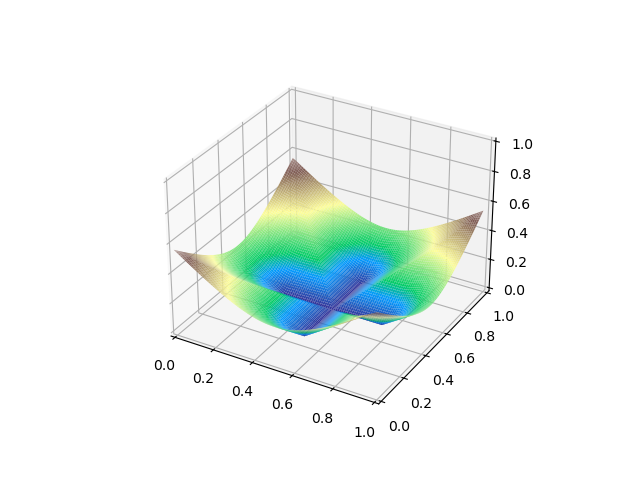

In [5]:
import numpy as np
%matplotlib widget
from SquareDivision.draw.draw import draw_func
from SquareDivision.src.distributions import distToIntervalAB, cross_ABCD
distToIntervalAB_kwargs = {'ax':0.25, 'ay':0.5, 'bx':0.75, 'by':0.5}
cross_ABCD_kwargs = {'ax':0.25, 'ay':0.5, 'bx':0.75, 'by':0.5, 'cx':0.5, "cy":0.25, 'dx':0.5, 'dy':0.75}
draw_func(cross_ABCD, func_kwargs = cross_ABCD_kwargs )